In [23]:
library(naturalsort)
library(data.table)
library(data.tree)
library(Biostrings)
library(fields)
dataDir <- '../../Data/SimOut1_2_2/'

In [24]:
flst<-list.files(dataDir) # Get list of files from directory
flst <- naturalsort(flst) # Natural sort the files
ncls <- c()
rs <- c()
k<-1
for (i in 1:(length(flst)-1)) {
    load(paste0(dataDir,flst[i]))
    if (CellPop$totalCount==1) {
        ncls[[k]] <- CellPop$ncells[length(CellPop$ncells)]
    }
    else {
        ncls[[k]] <- sum(vapply(CellPop$Get('ncells'),tail,n=1L,FUN.VALUE = numeric(1)))
    }
    rs[[k]] <- CellPop$Get('r')
    rm('CellPop')
    k <- k+1
    
}

Warning message:
“file ‘L1-cellpop_batch.r’ has magic number '#!/us'
  Use of save versions prior to 2 is deprecated”

ERROR: Error: bad restore file magic number (file may be corrupted) -- no data loaded


In [25]:
rs_var <- c()

for (i in 1:length(rs)) {
    
    if (length(rs[[i]])==1) {rs_var[i] <- 0}
    else {rs_var[i] <- var(rs[[i]])}

}

In [26]:
norml <- function(x) {
    x = (x-min(x))/(max(x)-min(x))
    return(x)}

In [28]:
matrix(ncls[1:20],nrow=4,ncol=5,byrow=TRUE)

65302,65358,65285,64676,64807
65600,65416,65215,65029,65345
65817,64844,65846,65026,64880
65363,65210,66785,64493,65207


In [29]:
matrix(rs_var[1:20],nrow=4,ncol=5,byrow=TRUE)

0.001221238,0.004375922,0.008604191,0.01499721,0.02014577
0.002089661,0.004094750,0.008186546,0.01280975,0.01889190
0.003762616,0.005031172,0.010278430,0.01257072,0.02075223
0.002099049,0.005263779,0.022920963,0.01579542,0.02218472


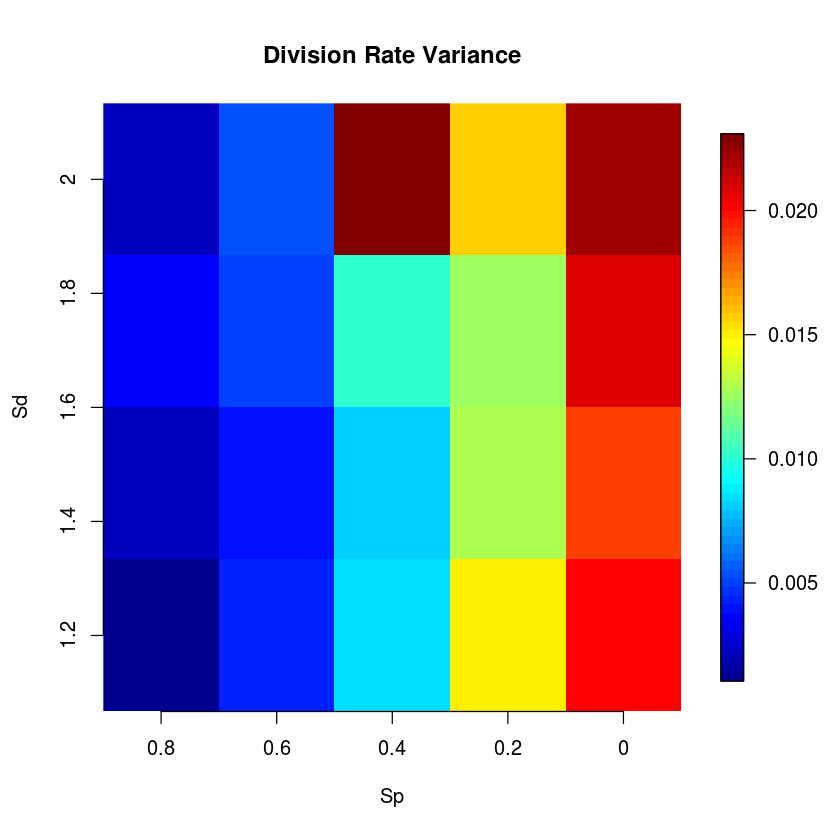

In [30]:
rotate <- function(x) t(apply(x, 2, rev))

image.plot(rotate(apply(matrix(rs_var[1:20],nrow=4,ncol=5,byrow=TRUE),2,rev)),axes=F)

title(main="Division Rate Variance",xlab='Sp',ylab='Sd');
axis(1, at=seq(0,1,0.25), labels=seq(0.8,0.0,-0.2)); 
axis(2, at=seq(0,1,0.25), labels=seq(1.2,2.0,0.2)); 


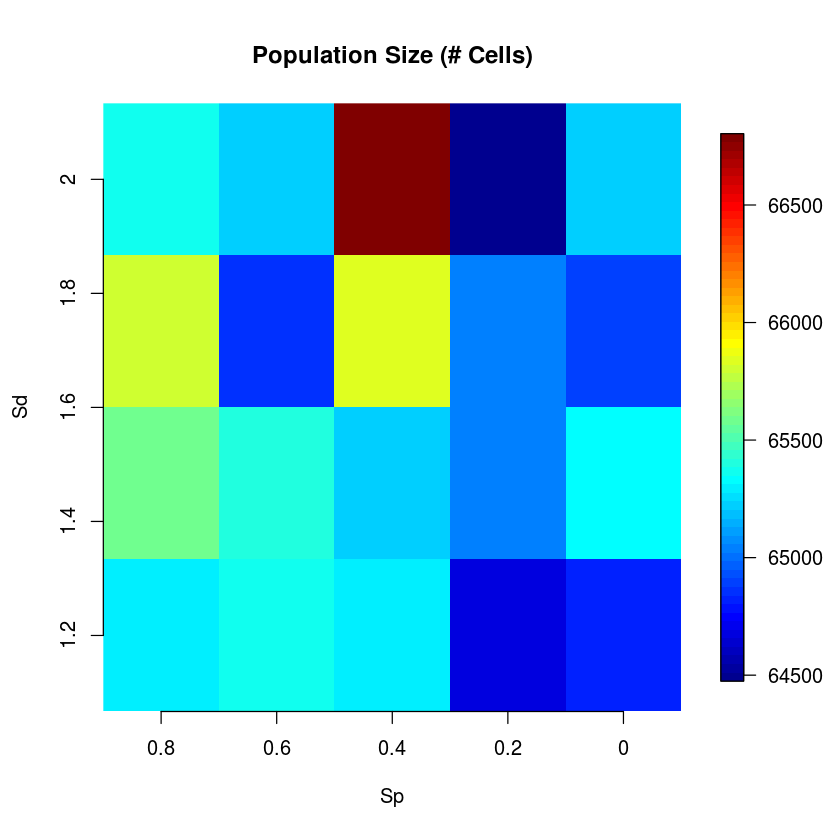

In [31]:
rotate <- function(x) t(apply(x, 2, rev))

image.plot(rotate(apply(matrix(ncls[1:20],nrow=4,ncol=5,byrow=TRUE),2,rev)),axes=F)

title(main="Population Size (# Cells)",xlab='Sp',ylab='Sd');
axis(1, at=seq(0,1,0.25), labels=seq(0.8,0.0,-0.2)); 
axis(2, at=seq(0,1,0.25), labels=seq(1.2,2.0,0.2)); 

In [ ]:
load('../../Data/SimOut1_2/0.rda')

In [ ]:
print(CellPop,'r')

In [ ]:
traversal <- Traverse(CellPop, traversal = "post-order", filterFun = function(x) x$r != 1)

In [ ]:
traversal[[1]]$tes

In [ ]:
# PURPOSE: Updates the gene annotation of the clone
#
# INPUT:
#   anno         (data frame) Annotation of genes (i.e. chromosome   start   end)
#   simout          (list of lists) gen_sim output
#   tes             (list of lists) Node tes
#
# OUTPUT: anno

update_anno <- function(anno,  tes) {
    
#     tmp = mapply(append, simout, tes, SIMPLIFY = FALSE)
    tmp=tes
    for (i in 1:length(tmp[[3]])) {
        # Shift the start loci of genes with start loci beyond the insertion by the width of the L1
        anno[anno$chrom==tmp[[2]][i] & anno$start>tmp[[3]][i],]$start <- anno[anno$chrom==tmp[[2]][i] & anno$start>tmp[[3]][i],]$start + width(tmp[[1]][i])  
        # Shift the end loci of genes with start loci beyond the insertion by the width of the L1
        anno[anno$chrom==tmp[[2]][i] & anno$start>tmp[[3]][i],]$end <- anno[anno$chrom==tmp[[2]][i] & anno$start>tmp[[3]][i],]$end + width(tmp[[1]][i])  
        # Shift the end locus of any gene with only end locus beyond the insertion by the width of the L1
        anno[anno$chrom==tmp[[2]][i] & anno$end>tmp[[3]][i] & anno$start<tmp[[3]][i],]$end <- anno[anno$chrom==tmp[[2]][i] & anno$end>tmp[[3]][i] & anno$start<tmp[[3]][i],]$end + width(tmp[[1]][i])        
    }
    return(anno) 
}

In [ ]:
rank_clone <- function(r, anno, sites_chrm, sites_loci, gainp, lossp) {

    gene_hits=0; # set counter to zero
    tsg_hits=0;
    for (i in 1:length(unique(sites_chrm))) { # loop over chromosomes inserted into
        tmp=anno[anno$chrom==unique(sites_chrm)[i],] # reduce annotation table to entries for current chrom
        chrmann_ntsg=tmp[tmp$istsg==0,]
        chrmann_tsg =tmp[tmp$istsg==1,]
        tmp = sites_loci[sites_chrm==unique(sites_chrm)[i]] # reduce insertion loci to entries for current chrom
        tmp_hits = between(tmp,chrmann_ntsg$start,chrmann_ntsg$end) # create logical for insertions, whether into non-tsg-gene or not
        gene_hits=gene_hits+length(which(tmp_hits==TRUE)) # count the number of non-tsg-gene insertions
#         print(gene_hits)
        tmp_hits  = between(tmp,chrmann_tsg$start,chrmann_tsg$end) # same for tsg-gene insertions
        tsg_hits =tsg_hits+length(which(tmp_hits==TRUE))
    }

    if (gene_hits > 0 || tsg_hits > 0){
        r=r*(lossp^gene_hits)*(gainp^tsg_hits)
    }

    if (r < 0.25) { # If the division rate is below 0.25, the clone stops growing
        r<-0
    }

    return(r)
}


In [ ]:
load('../../sim-develop/data/exann.rda')

In [ ]:
head(exann)

In [ ]:
k <- traversal[[1]]$tes

In [ ]:
k

In [ ]:
tmpAnn <- update_anno(exann,k)

In [ ]:
load('../../sim-develop/data/exann.rda')
for (node in traversal) {
    nodeTes <- node$tes
    tmpAnn <- update_anno(exann,nodeTes)
    
    
}

In [ ]:
r <- rank_clone(1,tmpAnn,k[[2]],k[[3]],1.2,.8)
r